In [1]:
import numpy as np
from numba import jit
from math import sqrt
from sys import float_info
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
@jit(nopython = True)
def squarenorm(x):
    return np.dot(x,x) # np.dot(x.conj(),x).real

@jit(nopython = True)
def cnorm(x):
    return x * x # x.real * x.real + x.imag * x.imag
    
#@jit(nopython = True,cache=True)
@jit(nopython=True)
def HouseholderVector(A):
    '''
    Compute real Householder vector of norm 2. 
    
    If no Householder is needed, the second argument returns one.
    '''
    squarelength = squarenorm(A[1:]) 
    if squarelength == 0:
        return A, 1 # A, A, 1
    normal     = A.copy()
    rotation   = 1 if A[0]>=0 else -1
    normal[0] = A[0] + sqrt(squarelength + cnorm(A[0]))*rotation
    normal *= sqrt(2. / (squarelength + cnorm(normal[0])))
    return normal, 0

@jit(nopython=True)
def leftHouse(A,normal):
    '''
    left Householder transformation where ||``normal``|| = sqrt 2
    '''
    tmp = normal @ A
    n = tmp.shape[0]
    for i in range(normal.shape[0]):
        for j in range(n):
            A[i,j] -= normal[i]*tmp[j]

@jit(nopython=True)
def rightHouse(A,normal):
    '''
    right Householder transformation where ||``normal``|| = sqrt 2
    '''
    tmp = A @ normal
    n = normal.shape[0]
    for i in range(tmp.shape[0]):
        for j in range(n):
            A[i,j] -= tmp[i]*normal[j]

#@jit(nopython = True,cache=True)
@jit(nopython=True)
def Hessenberg(A):
    ''' 
    Convert a matrix to upper-Hessenberg
    '''
    n = A.shape[0] 
    Q = np.eye(n,dtype=A.dtype)
    for i in range(n-1):
        normal, invalid = HouseholderVector(A[i+1:,i])
        if invalid:
            continue
        # A ->  [I- (2nn*)] A   =   A - 2n(n* A)
        leftHouse(A[i+1:,i:],normal)
        A[i+2:,i] = 0
        rightHouse(A[:,i+1:],normal)
        rightHouse(Q[:,i+1:],normal)
    return (Q,A)
    
@jit(nopython=True)
def ImplicitDoubleShift(A,Q,U,V):
    '''
    Perform a double shift on matrix A and update A,Q,U,V
    '''
    s = A[-1,-1] + A[-2,-2]
    t = A[-1,-1]*A[-2,-2] - A[-1,-2]*A[-2,-1]
    normal, invalid = HouseholderVector(np.array([
                A[0,0]*(A[0,0]-s) + A[0,1]*A[1,0] + t,
                A[1,0]*(A[0,0]+A[1,1]-s),
                A[1,0]*A[2,1]
                        ], dtype=A.dtype))
    if invalid:
        return
    leftHouse(A[:3,:],normal)
    rightHouse(A[:4,:3],normal)
    leftHouse(U[:3,:],normal)
    rightHouse(V[:,:3],normal)
    rightHouse(Q[:,:3],normal)

@jit(nopython=True)
def BuldgeChasing(A,Q,U,V):
    '''
    Convert the matrix back to Hessenberg and update A,Q,U,V
    '''
    n = A.shape[0]
    for i in range(1,n-1): 
        j = i + 3
        normal, invalid = HouseholderVector(A[i:j,i-1])
        if invalid:
            continue

        leftHouse(A[i:j,:],normal)
        A[i+1:j,i-1] = 0
        rightHouse(A[:j+1,i:j],normal)
        leftHouse(U[i:j,:],normal)
        rightHouse(V[:,i:j],normal)
        rightHouse(Q[:,i:j],normal)
        

@jit(nopython = True)
def Deflation(A,start,end,eps):
    '''
    Determine the eigenvalues to deflat and an irreduced Hessenberg matrix to operate on.
    '''
    for i in range(start,end):
        if A[i,i-1] != 0. and abs(A[i,i-1]) < eps * (abs(A[i,i])+abs(A[i-1,i-1])):
            A[i,i-1] = 0.
        
    for i in range(end-1,0,-1):
        if A[i,i-1] == 0.:
            if end - i <= 2:
                end = i
            else :
                start = i
                break
    else :
        start = 0
    return start , end

#@jit
def SchurDecomposition(A,maxiter=-1,copy=1,verbose=-1,printepoch=0):
    '''
    Compute Schur Decomposition for a real matrix. Return Q,T such that Q*AQ = T.

    ``maxiter`` the maximum iteration steps permitted, defaults to 3n + 60

    ``copy`` overwrites on A if ``copy`` == 0, defaults to 1

    ``verbose`` verbose the progress if True, defaults to True when n >= 500. 

    ``printepoch`` show how many iterations it takes if True, defaults to False
    '''
    n , lastend = A.shape
    start , end = 0 , lastend

    if copy: A = A.copy()
    if verbose < 0: verbose = 1 if n >= 500 else 0
    if maxiter < 0: maxiter = 3*n + 60
    eps = float_info.epsilon
    Q , A = Hessenberg(A)
    i = 0

    if verbose:
        pbar =  tqdm(total = n)
        pbar.set_description('Deflation')

    for i in range(maxiter):
        if end <= 2:
            break

        ImplicitDoubleShift(A[start:end,start:end],Q[:,start:end],
                            A[start:end,end:],A[:start,start:end])
        BuldgeChasing(A[start:end,start:end],Q[:,start:end],
                            A[start:end,end:],A[:start,start:end])

        # deflation
        start , end = Deflation(A,start,end,eps)

        if verbose and i % 10 == 0:
            pbar.set_postfix(steps = i)
            pbar.update(lastend - end)
            lastend = end
            
    else :
        print('Warning: Convergence Failure')
        
    if verbose:
        pbar.update(lastend)
        pbar.close()
    
    if printepoch:
        print('Steps =',i)

    return (Q , A)

In [3]:
n = 1000
np.random.seed(0)
A = np.random.randn(n*n).reshape((n,n))
#A = np.random.random((n,n))-0.5 #+ 1j*np.random.random((n,n))
#print(A)
#ans = sp.linalg.schur(A)
Q , B = SchurDecomposition(A,printepoch=1,verbose=1)

<ipython-input-2-fd8a713b6fe5>:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  normal, invalid = HouseholderVector(A[i+1:,i])
<ipython-input-2-fd8a713b6fe5>:61: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, A))
  leftHouse(A[i+1:,i:],normal)
<ipython-input-2-fd8a713b6fe5>:61: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, A))
  leftHouse(A[i+1:,i:],normal)
<ipython-input-2-fd8a713b6fe5>:63: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  rightHouse(A[:,i+1:],normal)
<ipython-input-2-fd8a713b6fe5>:63: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  rightHouse(A[:,i+1:],normal)
Deflation:   0%|          | 0/1000 [00:00<?, ?it/s]<ipyth

Steps = 1792


In [4]:
# Data
# 484m 24.4s  n = 8000 randn Q*AQ - B = 2.5182601591585813e-10      Q*Q - I = 4.68981849703805e-12    13505 iters
# 214m 10.8s  n = 6500 randn Q*AQ - B = 1.860677296855103e-10       Q*Q - I = 3.83229116343654e-12    11057 iters
# 103m 37.8s  n = 5000       Q*AQ - B = 1.1411477551545515e-10      Q*Q - I = 2.0928321616504077e-12  8577 iters
# 48m 3.1s    n = 4000 randn Q*AQ - B = 9.07271319294229e-11        Q*Q - I = 2.3742217299220984e-12  6836 iters
# 13m 41.8s   n = 3000       Q*AQ - B = 3.833070825628782e-11       Q*Q - I = 1.2521887384130525e-12  5158 iters
# 3m 30.9s   n = 2000        Q*AQ - B = 2.0067186990856122e-11      Q*Q - I = 8.49412669727072e-13    3463 iters
# 1m 26.7s   n = 1500        Q*AQ - B = 1.203190413969607e-11       Q*Q - I = 6.293800307572206e-13   2613 iters
# 1m 21.8s   n = 1500        Q*AQ - B = 6.214637239512623e-12       Q*Q - I = 9.168397247523479e-13   2635 iters
# 27.4s   n = 1000           Q*AQ - B = 1.1867459198653925e-11      Q*Q - I = 6.239258866135082e-13  1782 iters
# 3.9s   n = 500             Q*AQ - B = 4.2306266511828556e-12      Q*Q - I = 3.206861450323301e-13   900 iters

In [5]:
#print(np.max(Q.conj().T @ A @ Q - B))
#print(np.max(Q.T @ Q - np.eye(n)))

print(np.linalg.norm(Q.conj().T @ A @ Q - B))
print(np.linalg.norm(Q.T @ Q - np.eye(n)))

#print(np.linalg.eig(A))
#print(sys.float_info.epsilon)

#plt.imshow(np.abs(Q.T @ Q - np.eye(n)))
#plt.show()
#plt.imshow(B)
#plt.show()

1.1938972610857391e-11
6.150083246542916e-13


In [6]:
# Miscellaneous

#np.savetxt(r"D:\Python Projects\Data Science\Matrices\Numerical 1\Project 1\Size 4000 A.txt", A)
#np.savetxt(r"D:\Python Projects\Data Science\Matrices\Numerical 1\Project 1\Size 4000 Q.txt", Q)
#np.savetxt(r"D:\Python Projects\Data Science\Matrices\Numerical 1\Project 1\Size 4000 B.txt", B)

#n = 2000
#B = np.zeros((n,n))
#with open(r'D:\Python Projects\Data Science\Matrices\Numerical 1\Project 1\Size 2000 B.txt','r') as f:
#    for i in range(n):
#        B[i] = np.array([float(i) for i in f.readline().split()])

def printMatlab(A):
    return '[' + ';'.join([','.join([str(_) for _ in line]) for line in A]) +']'
#printMatlab(B[:10,:10])

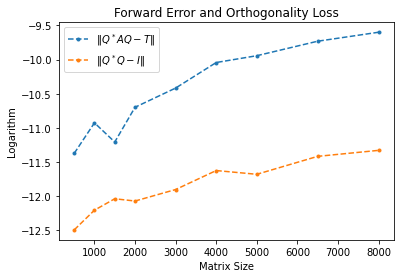

In [7]:
history = '''
 484m 24.4s  n = 8000       Q*AQ - B = 2.5182601591585813e-10      Q*Q - I = 4.68981849703805e-12    13505 iters
 214m 10.8s  n = 6500       Q*AQ - B = 1.860677296855103e-10       Q*Q - I = 3.83229116343654e-12    11057 iters
 103m 37.8s  n = 5000       Q*AQ - B = 1.1411477551545515e-10      Q*Q - I = 2.0928321616504077e-12  8577 iters
 48m 3.1s    n = 4000       Q*AQ - B = 9.07271319294229e-11        Q*Q - I = 2.3742217299220984e-12  6836 iters
 13m 41.8s   n = 3000       Q*AQ - B = 3.833070825628782e-11       Q*Q - I = 1.2521887384130525e-12  5158 iters
 3m 30.9s   n = 2000        Q*AQ - B = 2.0067186990856122e-11      Q*Q - I = 8.49412669727072e-13    3463 iters
 1m 21.8s   n = 1500        Q*AQ - B = 6.214637239512623e-12       Q*Q - I = 9.168397247523479e-13   2635 iters
 27.4s   n = 1000           Q*AQ - B = 1.1867459198653925e-11      Q*Q - I = 6.239258866135082e-13  1782 iters
 3.9s   n = 500             Q*AQ - B = 4.2306266511828556e-12      Q*Q - I = 3.206861450323301e-13   900 iters'''

x = [500,1000,1500,2000,3000,4000,5000,6500,8000]
resis = [float(_.split()[0]) for _ in history.split('Q*AQ - B = ')[1:]][::-1]
orthos = [float(_.split()[0]) for _ in  history.split('Q*Q - I = ')[1:]][::-1]
plt.plot(x,np.log10(resis),'.--')
plt.plot(x,np.log10(orthos),'.--')
#plt.scatter([500,1000,1500,2000,3000,5000],np.log10(resis),s=8)
#plt.scatter([500,1000,1500,2000,3000,5000],np.log10(orthos),s=8)
plt.legend(['$\Vert Q^*AQ - T\Vert$','$\Vert Q^*Q - I\Vert$'])
plt.xlabel('Matrix Size')
plt.ylabel('Logarithm')
plt.title('Forward Error and Orthogonality Loss')
plt.savefig('Stability.png',dpi=800,bbox_inches='tight')
plt.show()

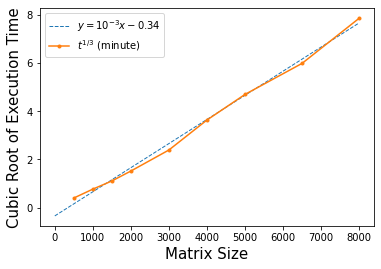

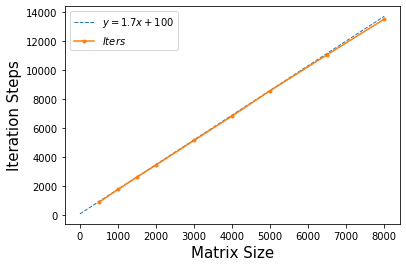

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = [500,1000,1500,2000,3000,4000,5000,6500,8000]
continue_x = np.linspace(0,8000,8000)
time = [3.9/60,27.4/60,1+21.8/60,3+30.9/60,13+41.8/60,48+3.1/60,103+37.8/60,214+10.8/60,484+24.4/60]
iters = [900,1782,2635,3463,5158,6836,8577,11057,13505]
plt.plot(continue_x,continue_x*1e-3-0.34,'--',linewidth=1)
plt.plot(x, np.power(time,1./3),'.-')
plt.legend(['$y=10^{-3}x-0.34$','$t^{1/3}$ (minute)'])
plt.xlabel('Matrix Size',fontsize=15)
plt.ylabel('Cubic Root of Execution Time',fontsize=15)
plt.savefig('Running Time.png',dpi=500,bbox_inches='tight')
#print(np.polyfit(x,np.power(time,1./3),1))
plt.show()

plt.plot(continue_x,continue_x*1.7+100,'--',linewidth=1)
plt.plot(x,iters,'.-')
plt.legend(['$y=1.7x+100$','$Iters$'])
plt.xlabel('Matrix Size',fontsize=15)
plt.ylabel('Iteration Steps',fontsize=15)
plt.savefig('Iteration Steps.png',dpi=500,bbox_inches='tight')
#print(np.polyfit(x,iters,1))
plt.show()


In [9]:
n = 4
np.random.seed(0)
for i in tqdm(range(100000)):
    A = np.random.randn(n*n).reshape((n,n))
    Q , B = SchurDecomposition(A)
    #print(np.linalg.norm(Q.conj().T @ A @ Q - B))
    #print(np.linalg.norm(Q.T @ Q - np.eye(n)))

100%|██████████| 100000/100000 [00:09<00:00, 10037.56it/s]


Steps = 999999
[[ 0.00000000e+00 -1.00496269e+00  0.00000000e+00 -9.95012575e-03]
 [-9.95012561e-01  0.00000000e+00 -4.97504973e-05  0.00000000e+00]
 [ 0.00000000e+00  9.99987624e-03  0.00000000e+00 -9.94962811e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.00501244e+00  0.00000000e+00]]
[-0.9999875+0.005j -0.9999875-0.005j  0.9999875+0.005j  0.9999875-0.005j]
(0.999987499921874+0.005j)


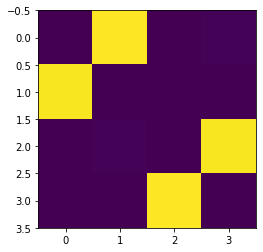

In [10]:
# Example that the algorithm fails
eta = 1e-2
A = np.reshape(np.array([0,1,0,0,1,0,eta,0,0,-eta,0,1,0,0,1,0],dtype='float64'),(4,4))
np.linalg.eigvals(A)
Q , R = SchurDecomposition(A.copy(),maxiter=1000000,printepoch=1)
print(R)
#print(printMatlab(R))
plt.imshow(np.abs(R))
print(np.linalg.eigvals(A))

eig = sqrt(4 - eta*eta)/2. + eta/2. * 1j
print(eig)
#print(np.linalg.det(A - np.eye(4) * eig))

In [11]:
n = 500
def Cauchy(n):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            A[i,j] = 1./(i+j+1)
    return A
A = Cauchy(n)
Q , B = SchurDecomposition(A)
print(np.linalg.norm(Q.conj().T @ A @ Q - B))
print(np.linalg.norm(Q.T @ Q - np.eye(n)))

Deflation: 100%|██████████| 500/500 [00:03<00:00, 157.77it/s, steps=830]


1.0068553732979641e-14
2.993470470440246e-13
